Przygotujemy model regresji wykorzystując do tego techniki budowy modeli klasyfikacyjnych. Skorzystam w ćwiczeniu z danych California Housing ale w wersji uprosczninej tj. tylko cechy numeryczne oraz bez wartości null. Nazwałem ćwiczenie indujcją ponieważ analogicznie jak w indukcji potrafimy coś zrobić dla niższego wymiaru i zakładamy prawdziwość tezy dla wyższego wymiaru. W tym wypadku tezą jest dobrze zbudowany model :)

In [1]:
# importujemy dane 
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()

X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, test_size=0.2)

In [30]:
# jako model bazowy wykorzystam model regresji liniowej
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train) 

y_hat = model.predict(X_train)
y_hat_test_r = model.predict(X_test)

print(model.coef_)
print(housing.feature_names)

[ 4.35625088e-01  9.78826180e-03 -1.08625595e-01  6.39181946e-01
 -2.72754052e-06 -3.52526932e-03 -4.20119232e-01 -4.31468812e-01]
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [3]:
# miary dopasowania na zbiorze treningowym oraz walidacyjnym

from sklearn.metrics import mean_squared_error

print("Wartość MSE dla zbioru treningowego to {0:.4f}, dla testowego to {1:.4f}".
      format(mean_squared_error(y_train, y_hat, squared=True), mean_squared_error(y_test, y_hat_test_r, squared=True)))

print("Wartość RMSE dla zbioru treningowego to {0:.4f}, dla testowego to {1:.4f}".
      format(mean_squared_error(y_train, y_hat, squared=False), mean_squared_error(y_test, y_hat_test_r, squared=False)))


Wartość MSE dla zbioru treningowego to 0.5268, dla testowego to 0.5149
Wartość RMSE dla zbioru treningowego to 0.7258, dla testowego to 0.7176


In [4]:
# kilka sprawdzeń z jakimi zmiennymi mamy do czynienia
import numpy as np
from statistics import pstdev, median
print(np.average(y_train))
print(np.average(y_test))

print(pstdev(y_train))
print(pstdev(y_test))


2.0730663075339146
2.050525615310078
1.1556903749012377
1.1466752215020783


<AxesSubplot:>

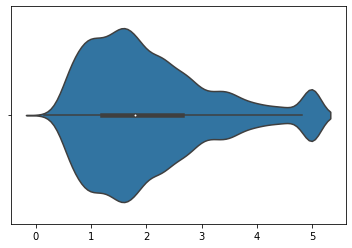

In [5]:
# jeszcze rozkład pudełkowy zmiennej celu
import matplotlib.pyplot as plt
import seaborn as sns

sns.violinplot(x=y_train)

<AxesSubplot:>

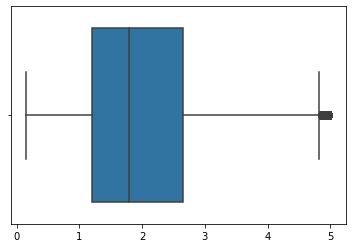

In [6]:
sns.boxplot(x=y_train)

Występuje pare obserwacji odstających, można je "przyciąć" do wartości równej rórnemu kwantylowi albo usunąć. 
Na potrzeby tego ćwiczenia pozostawiam je i wykorzystam w procesie normalizacji minmax 

In [7]:
# wartość współczynnika determinacji 
from sklearn.metrics import r2_score

print("Wartość R2 na zbiorze treningowym to {0:4f}, na zbiorze testowym to {1:4f}".
      format(r2_score(y_train, y_hat), r2_score(y_test, y_hat_test_r)))

Wartość R2 na zbiorze treningowym to 0.605590, na zbiorze testowym to 0.608396


Przechodzę teraz do budowy modelu regresji korzystając z modelu kategorialnego.
W tym celu skorzystam z modelu regresji logistycznej chociaż aby lepiej dobrać funkcję należałoby najpierw lepiej przyglądnąć się 
rozkładowi zmiennej celu

<AxesSubplot:>

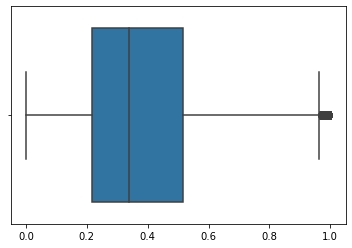

In [8]:
# normalizacja zmiennej celu oraz pozbycie się wartości odstających. 
#y_prim = (y - y_min)/(y_max-y_min)*(new_y_max - new_y_min)

# należy pamiętać, żeby skorzystać z tego samego zestawu parametrów nomralizacji danych również na zbiorze walidacyjnym
y_min = np.min(y_train) 
y_max = np.max(y_train)

y_train_b = [(y - y_min)/(y_max - y_min) for y in y_train]
#y_test_b = [(y - y_min)/(y_max - y_min) for y in y_test]

sns.boxplot(x= y_train_b)

In [21]:
# generuję listę liczb pseudolosowych na podstawie których dokonam kodowania targetu na 0 i 1
import random
tresh_list = []
for i in range(len(y_train_b)):  #16512
    tmp = random.random()
    tresh_list.append(tmp)

y_train_cat = [1 if y >= t else 0 for y,t in zip(y_train_b, tresh_list)]

# sprawdzenie czy średnia się zgadza, można wykorzystać jakiś test ale przy tej skali prawo wielkich liczb powinno zadziałać 
print(np.average(y_train_cat))
print(np.average(y_train_b))

0.3925024224806202
0.3965089437845441


 W następnym kroku zbuduję model dla problemu binarnego. Skorzystam z Catboosta zapominając na chwilę, że może on rozwiązywać również problemy regresyjne :)

In [31]:
from catboost import CatBoostClassifier, Pool

# odpuszczam sobie przygotowanie zmiennych kategorialnych bo takowych w zbiorze nie ma

#parametryzujemy model
cbc = CatBoostClassifier(n_estimators=100,
                         loss_function='Logloss',
                         learning_rate=0.1,
                         depth=3, task_type='GPU',
                         random_state=128262,
                         verbose=False)


# konsertujemy zbiory do typu Pool
pool_train = Pool(X_train, y_train_cat)

pool_test = Pool(X_test, cat_features = [])
cbc.fit(pool_train)
y_hat_test = cbc.predict_proba(pool_test)

# odwrotne działanie do min max
y_hat_test_conv = [y*(y_max - y_min) + y_min for y in y_hat_test[:,1]]


from sklearn.metrics import mean_squared_error, r2_score


print("Wartość MSE to {0:.4f}, RMSE to {1:.4f}, a R2 wynosi {2:4f}".
      format(mean_squared_error(y_test, y_hat_test_conv, squared=True), \
             mean_squared_error(y_test, y_hat_test_conv, squared=False), \
            r2_score(y_test, y_hat_test_conv)))
print("Dla przypomnienia wartości dla modelu regresji wartości te na zbiorze testowym wynosiły")

print("Wartość dla Regresji: MSE to {0:.4f}, RMSE to {1:.4f}, a R2 wynosi {2:4f}".
      format(mean_squared_error(y_test, y_hat_test_r, squared=True), \
             mean_squared_error(y_test, y_hat_test_r, squared=False), \
            r2_score(y_test, y_hat_test_r)))


Wartość MSE to 0.3352, RMSE to 0.5790, a R2 wynosi 0.745040
Dla przypomnienia wartości dla modelu regresji wartości te na zbiorze testowym wynosiły
Wartość dla Regresji: MSE to 0.5149, RMSE to 0.7176, a R2 wynosi 0.608396


Porównajmy jeszcze rozkłady obu modeli: 

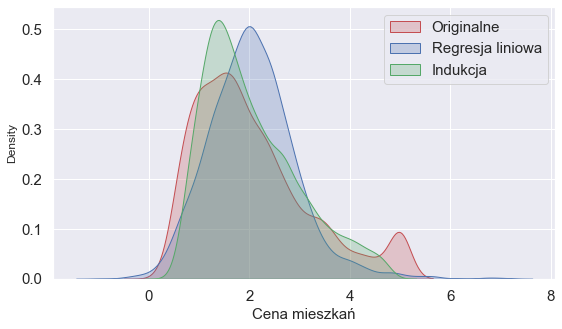

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
plt.figure(figsize=(9,5))


fig = sns.kdeplot(y_test, label='Originalne', shade=True, color="r", common_grid=True)
fig = sns.kdeplot(y_hat_test_r, label='Regresja liniowa', shade=True, color="b", common_grid=True)
fig = sns.kdeplot(y_hat_test_conv, label='Indukcja', shade=True, color="g", common_grid=True)

plt.xlabel('Cena mieszkań', fontsize=15)
#plt.xlim(0,1)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=15, pad=5)
#plt.savefig("double_density.png", format='png', dpi=300, facecolor="White")
plt.show()